# Mouse skull 3D v00
In this notebook we run registration for mouse data with skull, MD816.  Here we just look at 3D datasets.


Note atlas MRI is 50,50,50 micron

and target CT is 64,64,64, micron



In [23]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os


# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from 'c:\\Users\\BGAdmin\\emlddmm\\emlddmm.py'>

In [24]:
atlas_name = 'C:\\Users\\BGAdmin\\data\\MD816/HR_NIHxCSHL_50um_14T_M1_masked.vtk'
target_name = 'C:\\Users\\BGAdmin\\data\\MD816/ct_mask.vtk'


config_file = 'configMD816_MR_to_CT.json'
output_dir = 'MD816_test_00/'

In [25]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[50. 50. 50.]


Text(0.5, 0.98, 'Atlas image')

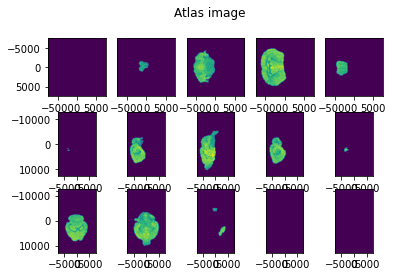

In [26]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')


Text(0.5, 1.0, 'Atlas pixel intensities')

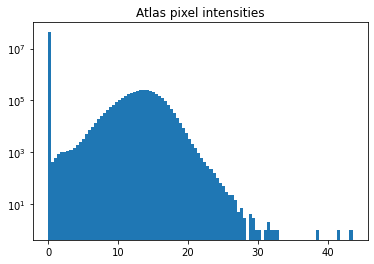

In [27]:
fig,ax = plt.subplots()
ax.hist(I.ravel(),bins=100,log=True)
ax.set_title('Atlas pixel intensities')

In [28]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[100.0, 100.0, 100.0]


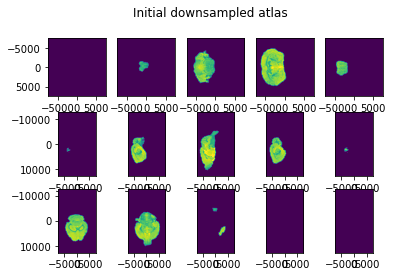

In [29]:
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Initial downsampled atlas')
fig[0].canvas.draw()

Found extension .vtk
[64. 64. 64.]


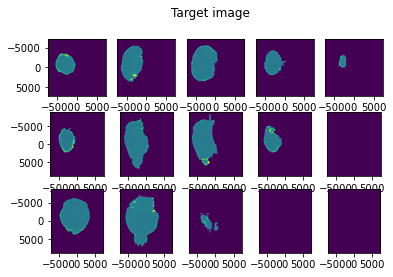

In [30]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
fig[0].canvas.draw()
W0 = np.ones_like(J[0])


Text(0.5, 1.0, 'Target pixel intensities')

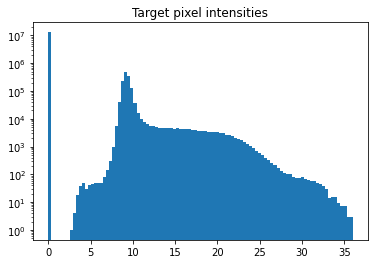

In [31]:
fig,ax = plt.subplots()
ax.hist(J.ravel(),bins=100,log=True)
ax.set_title('Target pixel intensities')

In [32]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
print(dJ)
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

[128.0, 128.0, 128.0]


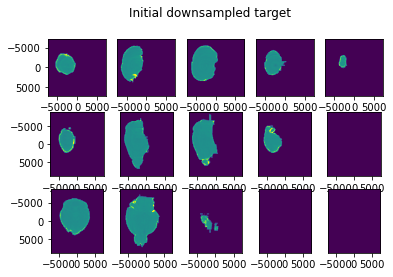

In [33]:
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')
fig[0].canvas.draw()


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Text(0.5, 0.98, 'Initial transformed atlas')

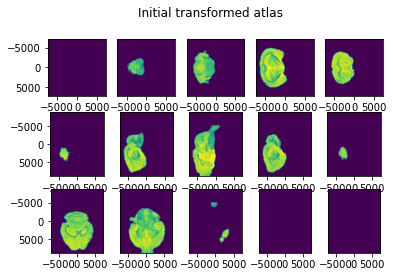

In [34]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)
print(A)

# this affine matrix should be 4x4, but it may be 1x4x4
while A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

Found 2 scales
dv tensor([300., 300., 300.], device='cuda:0')
a scale is 1000.0


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 0
Finished iteration 10
Iteration 20, translation oscilating, reducing eA to 450000.0
Finished iteration 20
Iteration 30, translation oscilating, reducing eA to 405000.0
Finished iteration 30
Iteration 40, translation oscilating, reducing eA to 364500.0
Finished iteration 40
Iteration 50, linear oscilating, reducing eA to 328050.0


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 50
Iteration 60, translation oscilating, reducing eA to 295245.0
Finished iteration 60
Iteration 70, translation oscilating, reducing eA to 265720.5
Finished iteration 70
Iteration 80, linear oscilating, reducing eA to 239148.45
Finished iteration 80
Iteration 90, translation oscilating, reducing eA to 215233.605
Finished iteration 90
Iteration 100, translation oscilating, reducing eA to 193710.2445


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 100
Iteration 110, translation oscilating, reducing eA to 174339.22005
Finished iteration 110
Finished iteration 120
Finished iteration 130
Iteration 140, translation oscilating, reducing eA to 156905.298045
Finished iteration 140
Iteration 150, translation oscilating, reducing eA to 141214.7682405


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 150
Iteration 160, translation oscilating, reducing eA to 127093.29141645001
Finished iteration 160
Finished iteration 170
Finished iteration 180
Iteration 190, linear oscilating, reducing eA to 114383.96227480502
Finished iteration 190


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 200
Iteration 210, translation oscilating, reducing eA to 102945.56604732452
Finished iteration 210
Finished iteration 220
Iteration 230, translation oscilating, reducing eA to 92651.00944259207
Finished iteration 230
Finished iteration 240


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 250
Iteration 260, translation oscilating, reducing eA to 83385.90849833286
Finished iteration 260
Finished iteration 270
Finished iteration 280
Finished iteration 290


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 300
Finished iteration 310
Iteration 320, translation oscilating, reducing eA to 75047.31764849958
Finished iteration 320
Iteration 330, translation oscilating, reducing eA to 67542.58588364962
Finished iteration 330
Finished iteration 340
Iteration 350, translation oscilating, reducing eA to 60788.32729528466


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 350
Finished iteration 360
Iteration 370, translation oscilating, reducing eA to 54709.4945657562
Finished iteration 370
Iteration 380, translation oscilating, reducing eA to 49238.54510918058
Finished iteration 380
Iteration 390, translation oscilating, reducing eA to 44314.690598262525
Finished iteration 390


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 400
Iteration 410, linear oscilating, reducing eA to 39883.22153843627
Finished iteration 410
Finished iteration 420
Finished iteration 430
Iteration 440, translation oscilating, reducing eA to 35894.899384592645
Finished iteration 440
Iteration 450, translation oscilating, reducing eA to 32305.40944613338


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 450
Finished iteration 460
Finished iteration 470
Finished iteration 480
Finished iteration 490
Iteration 500, translation oscilating, reducing eA to 29074.868501520043


c:\Users\BGAdmin\emlddmm\emlddmm.py:85: RuntimeWarning: invalid value encountered in true_divide
  # for rgb I'll scale it, otherwise I won't, so I can use colorbars


Finished iteration 500
Iteration 510, linear oscilating, reducing eA to 26167.38165136804
Finished iteration 510
Finished iteration 520
Finished iteration 530
Finished iteration 540
Iteration 550, translation oscilating, reducing eA to 23550.643486231234
Finished iteration 550
Finished iteration 560
Finished iteration 570
Iteration 580, translation oscilating, reducing eA to 21195.57913760811
Finished iteration 580
Iteration 590, translation oscilating, reducing eA to 19076.0212238473
Finished iteration 590
Iteration 600, translation oscilating, reducing eA to 17168.41910146257
Finished iteration 600
Finished iteration 610
Iteration 620, translation oscilating, reducing eA to 15451.577191316312
Finished iteration 620
Finished iteration 630
Finished iteration 640
Iteration 650, translation oscilating, reducing eA to 13906.419472184682
Finished iteration 650
Iteration 660, linear oscilating, reducing eA to 12515.777524966214
Finished iteration 660
Finished iteration 670
Finished iteratio

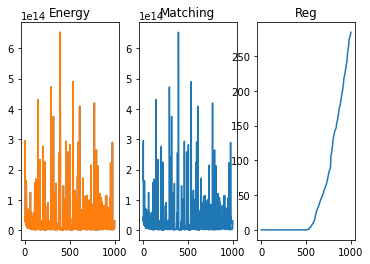

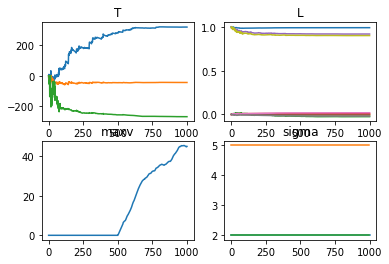

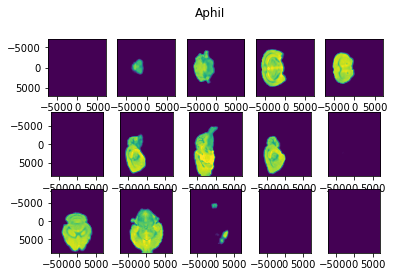

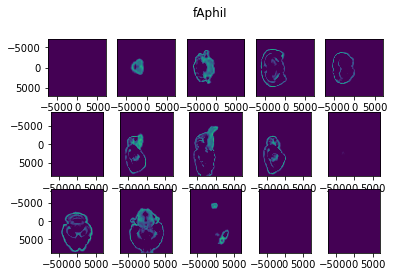

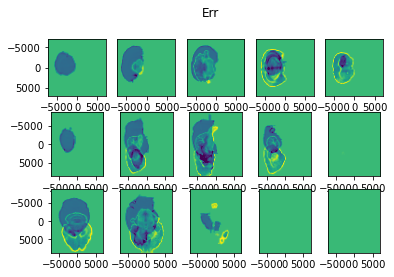

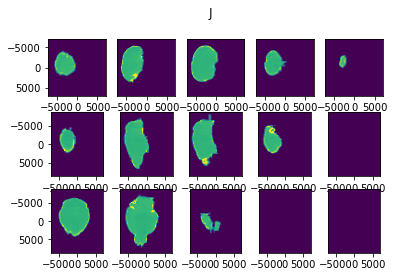

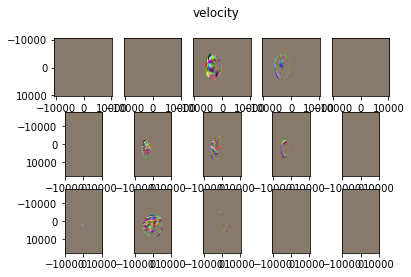

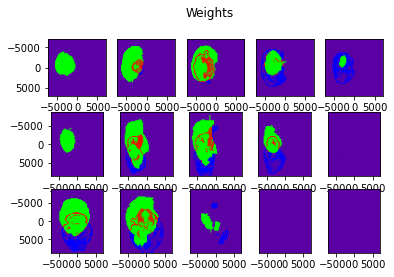

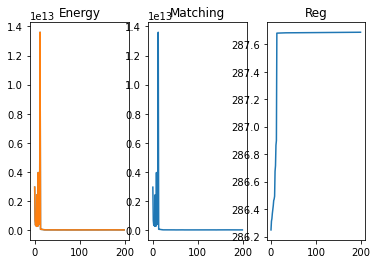

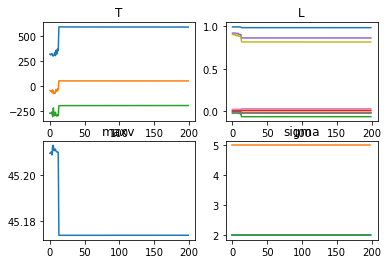

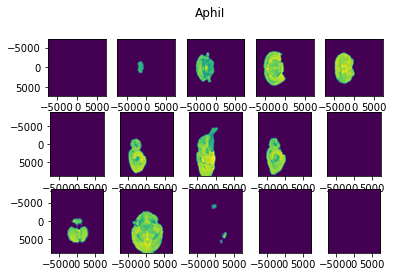

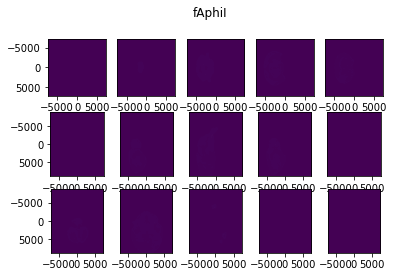

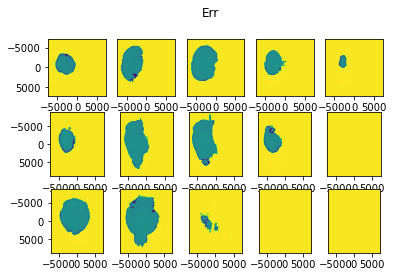

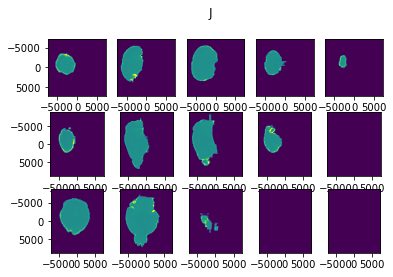

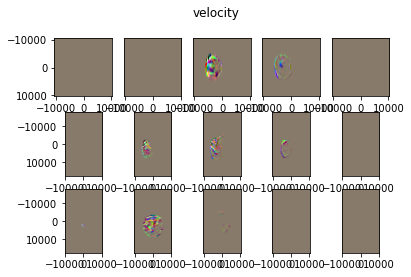

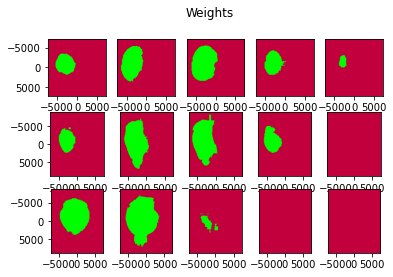

In [35]:
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [36]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

cpu
output dir is MD816_test_00/qc/


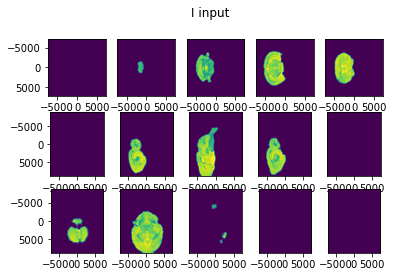

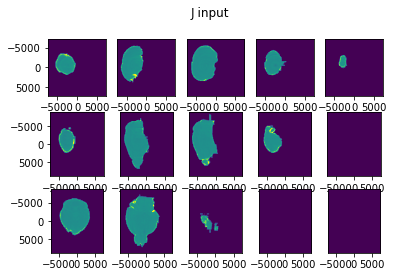

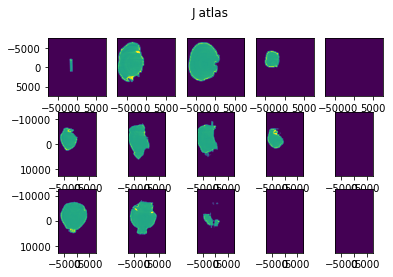

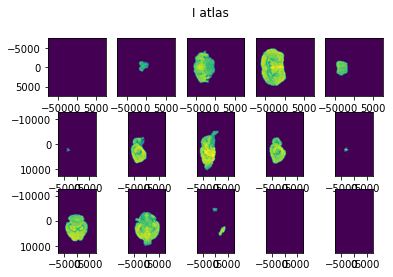

In [37]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J)

In [38]:
# apply forward transform (target image to atlas)
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

starting to compose sequence with transforms MD816_test_00/


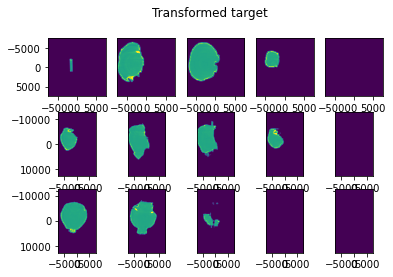

In [39]:
fig = emlddmm.draw(Jt,xI)
fig[0].suptitle('Transformed target')
fig[0].canvas.draw()

In [40]:
# apply backward transform (atlas images to target)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)


starting to compose sequence with transforms MD816_test_00/


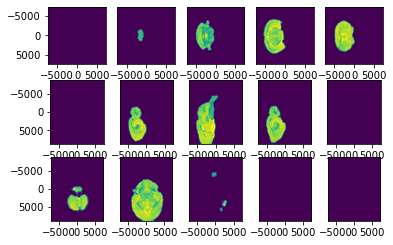

In [41]:
fig = emlddmm.draw(It,xJ)
fig[0].canvas.draw()


In [42]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [43]:
# write transformed images, these are at low res
imp.reload(emlddmm)
ext = '.vtk'
if ext[0] != '.': ext = '.' + ext
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas'+ext),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target'+ext),xI,It,'atlas_to_target')


Found extension .vtk
Found extension .vtk


Found extension .vtk
[50. 50. 50.]
Found extension .vtk
[64. 64. 64.]
starting to compose sequence with transforms MD816_test_00/
Found extension .vtk


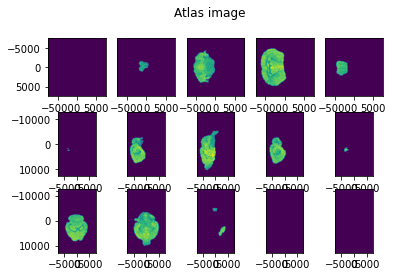

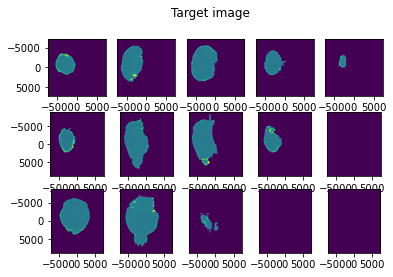

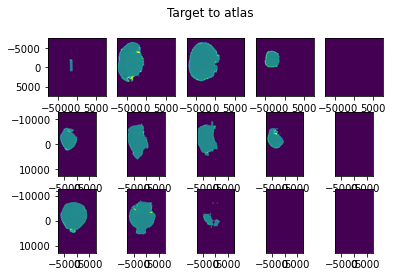

In [44]:
# reload atlas at full res 
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')



# transform target images at full res
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
fig[0].canvas.draw()

Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

fig = emlddmm.draw(Jt,xI)
fig[0].suptitle('Target to atlas')
fig[0].canvas.draw()

# write out
outname = os.path.splitext(os.path.split(target_name)[1])[0]
outname = os.path.join(atlas_output_dir,outname+ext)
emlddmm.write_data(outname,xI,Jt,'target_to_atlas')